# LSTM Deep Learning Model (Torch-Based)

**Objective**: Implement LSTM with PyTorch for better CUDA support and forward-fill validation

**Key Improvements**:
- **PyTorch**: Better GPU utilization and CUDA support
- **Forward Fill**: Walk-forward validation without look-ahead bias
- **Multi-step Forecasting**: Proper 5-day ahead predictions

**Architecture**: Multi-layer LSTM with dropout for regularization

## 1. Import Libraries and Check CUDA

In [40]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep Learning - PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Plot settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠ CUDA not available - running on CPU")

✓ Libraries imported successfully
PyTorch version: 2.9.0
Device: mps
⚠ CUDA not available - running on CPU


## 2. Load and Prepare Data

In [41]:
# Load dataset
df = pd.read_csv('../data/gold_silver.csv')

# Convert to datetime and set proper frequency
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.sort_values('DATE')
df.set_index('DATE', inplace=True)
df = df.asfreq('B')  # Business day frequency

# Calculate log returns
df['GOLD_LOG_RETURN'] = np.log(df['GOLD_PRICE']) - np.log(df['GOLD_PRICE'].shift(1))
df = df.dropna(subset=['GOLD_LOG_RETURN'])

print(f"Dataset: {len(df)} observations")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Frequency: {df.index.freq}")

Dataset: 10525 observations
Date range: 1985-01-03 00:00:00 to 2025-09-10 00:00:00
Frequency: None


## 3. Define PyTorch LSTM Model

In [42]:
class LSTMForecaster(nn.Module):
    """PyTorch LSTM model for time series forecasting"""
    
    def __init__(self, input_size=1, hidden_size_1=64, hidden_size_2=32, 
                 forecast_horizon=5, dropout=0.2):
        super(LSTMForecaster, self).__init__()
        
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        
        # First LSTM layer
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size_1,
            batch_first=True,
            dropout=0 if hidden_size_2 == 0 else dropout
        )
        
        # Second LSTM layer
        self.lstm2 = nn.LSTM(
            input_size=hidden_size_1,
            hidden_size=hidden_size_2,
            batch_first=True
        )
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
        # Dense layers
        self.fc1 = nn.Linear(hidden_size_2, 16)
        self.relu = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout * 0.5)
        
        # Output layer
        self.fc2 = nn.Linear(16, forecast_horizon)
    
    def forward(self, x):
        # First LSTM
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout1(lstm1_out)
        
        # Second LSTM
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.dropout2(lstm2_out)
        
        # Take only last timestep
        last_timestep = lstm2_out[:, -1, :]
        
        # Dense layers
        x = self.fc1(last_timestep)
        x = self.relu(x)
        x = self.dropout3(x)
        
        # Output
        output = self.fc2(x)
        
        return output

print("✓ LSTM model class defined")

✓ LSTM model class defined


## 4. Create Sequences for LSTM

In [43]:
def create_sequences(data, lookback, forecast_horizon):
    """
    Create sequences for LSTM
    X: [samples, lookback, features]
    y: [samples, forecast_horizon]
    """
    X, y = [], []
    for i in range(len(data) - lookback - forecast_horizon + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast_horizon])
    return np.array(X), np.array(y)

# Parameters
lookback = 20  # Use past 20 days
forecast_horizon = 5  # Predict next 5 days

# Use log returns as target
data = df['GOLD_LOG_RETURN'].values

# Create sequences
X, y = create_sequences(data, lookback, forecast_horizon)

print(f"Sequence shape:")
print(f"  X (input):  {X.shape} - [samples, lookback, features]")
print(f"  y (output): {y.shape} - [samples, forecast_horizon]")
print(f"\nExample: Use {lookback} past days to predict next {forecast_horizon} days")

Sequence shape:
  X (input):  (10501, 20) - [samples, lookback, features]
  y (output): (10501, 5) - [samples, forecast_horizon]

Example: Use 20 past days to predict next 5 days


## 5. Train-Test Split and Scaling

In [44]:
# 80-20 split (chronological)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Train set: {len(X_train)} sequences")
print(f"Test set:  {len(X_test)} sequences")

# Scale data for neural network (fit on train only)
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# Reshape for scaling
X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(-1).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(-1).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

print("\n✓ Data scaled to [-1, 1] range")
print(f"✓ Tensors moved to {device}")

Train set: 8400 sequences
Test set:  2101 sequences

✓ Data scaled to [-1, 1] range
✓ Tensors moved to mps


## 6. Create DataLoader for Batch Training

In [45]:
# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_size = int(len(train_dataset) * 0.2)
train_size_actual = len(train_dataset) - val_size

train_subset, val_subset = torch.utils.data.random_split(
    train_dataset, 
    [train_size_actual, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Batch size: {batch_size}")

Train batches: 210
Validation batches: 53
Batch size: 32


## 7. Initialize Model and Training Components

In [46]:
# Initialize model
model = LSTMForecaster(
    input_size=1,
    hidden_size_1=64,
    hidden_size_2=32,
    forecast_horizon=forecast_horizon,
    dropout=0.2
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=10, 
    min_lr=1e-6
)

print("✓ Model initialized")
print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

✓ Model initialized

Model Architecture:
LSTMForecaster(
  (lstm1): LSTM(1, 64, batch_first=True, dropout=0.2)
  (lstm2): LSTM(64, 32, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (relu): ReLU()
  (dropout3): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=16, out_features=5, bias=True)
)

Total parameters: 30309
Trainable parameters: 30309


## 8. Training Loop with Early Stopping

In [47]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader:
        # Forward pass
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(val_loader)

# Training
num_epochs = 100
patience = 20
best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'val_loss': []}

print("Training LSTM with PyTorch... (this may take 5-10 minutes)\n")
print(f"Epoch | Train Loss | Val Loss   | Best Val   | Status")
print("-" * 65)

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Early stopping
    status = ""
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), '../models/lstm-univar/best_model.pt')
        status = "✓ Saved"
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n⚠ Early stopping at epoch {epoch+1}")
            break
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"{epoch+1:5d} | {train_loss:10.6f} | {val_loss:10.6f} | {best_val_loss:10.6f} | {status}")

# Load best model
model.load_state_dict(torch.load('../models/lstm-univar/best_model.pt'))
print(f"\n✓ Training completed")
print(f"Best validation loss: {best_val_loss:.6f}")

Training LSTM with PyTorch... (this may take 5-10 minutes)

Epoch | Train Loss | Val Loss   | Best Val   | Status
-----------------------------------------------------------------
    1 |   0.013067 |   0.009922 |   0.009922 | ✓ Saved
    5 |   0.010870 |   0.009959 |   0.009908 | 
   10 |   0.010834 |   0.009912 |   0.009908 | 
   15 |   0.010811 |   0.009921 |   0.009908 | 
   20 |   0.010803 |   0.009919 |   0.009905 | 
   25 |   0.010803 |   0.009908 |   0.009905 | 
   30 |   0.010801 |   0.009907 |   0.009905 | 
   35 |   0.010800 |   0.009907 |   0.009905 | 

⚠ Early stopping at epoch 36

✓ Training completed
Best validation loss: 0.009905


## 9. Plot Training History

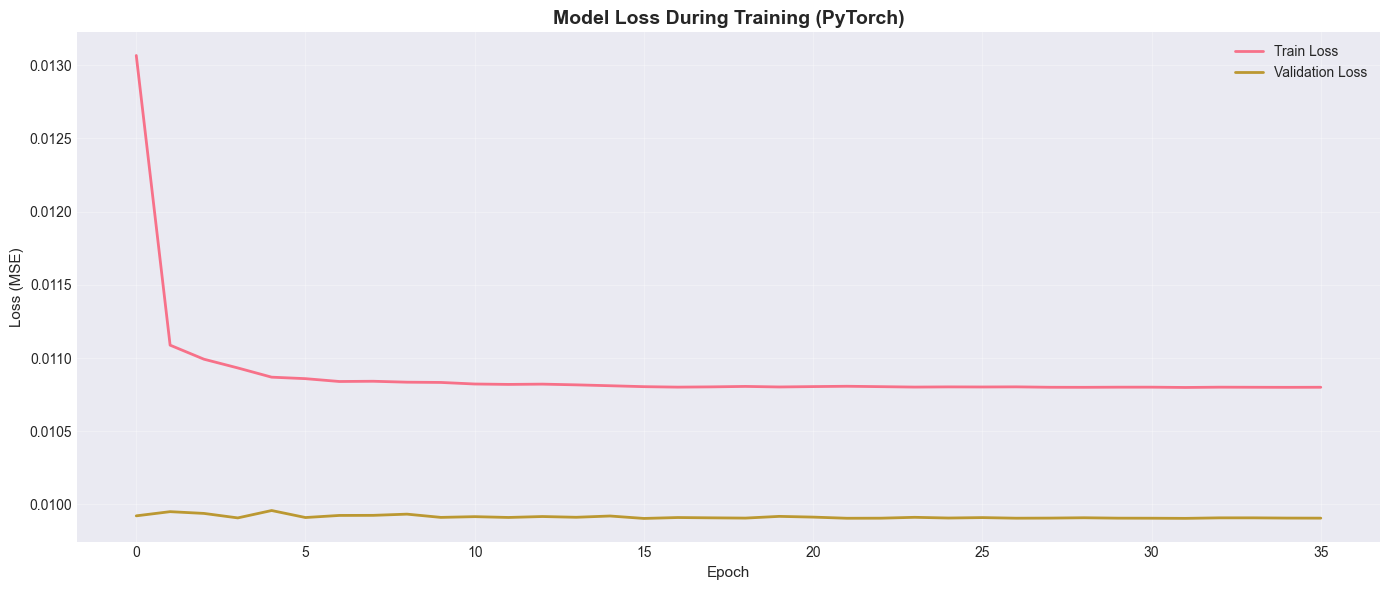

In [48]:
# Plot training history
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax.plot(history['val_loss'], label='Validation Loss', linewidth=2)
ax.set_title('Model Loss During Training (PyTorch)', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss (MSE)', fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Forward-Fill Walk-Forward Validation

**Critical**: Simulate real-world forecasting with forward-fill approach

In [49]:
def forward_fill_forecast(model, data, train_size, lookback, forecast_horizon, scaler_X, scaler_y, device):
    """
    Walk-forward validation with forward fill
    - At each step, use only past data
    - Make 5-day ahead predictions
    - Move forward 5 days and repeat
    """
    model.eval()
    predictions = []
    actuals = []
    
    # Start from first possible test point
    test_start = train_size + lookback
    
    with torch.no_grad():
        # Walk forward by forecast_horizon steps
        for i in range(test_start, len(data) - forecast_horizon + 1, forecast_horizon):
            # Get lookback window
            X_window = data[i - lookback:i]
            
            # Scale
            X_scaled = scaler_X.transform(X_window.reshape(-1, 1)).reshape(1, lookback, 1)
            X_tensor = torch.FloatTensor(X_scaled).to(device)
            
            # Predict
            y_pred_scaled = model(X_tensor).cpu().numpy()
            y_pred = scaler_y.inverse_transform(y_pred_scaled)[0]
            
            # Get actual values
            y_actual = data[i:i + forecast_horizon]
            
            # Store (only if we have all forecast_horizon values)
            if len(y_actual) == forecast_horizon:
                predictions.extend(y_pred)
                actuals.extend(y_actual)
    
    return np.array(predictions), np.array(actuals)

# Perform forward-fill forecasting
print("Performing walk-forward validation with forward fill...\n")

predictions_log_returns, actuals_log_returns = forward_fill_forecast(
    model=model,
    data=data,
    train_size=train_size,
    lookback=lookback,
    forecast_horizon=forecast_horizon,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    device=device
)

print(f"✓ Generated {len(predictions_log_returns)} forward-fill predictions")
print(f"✓ Number of forecast windows: {len(predictions_log_returns) // forecast_horizon}")

Performing walk-forward validation with forward fill...

✓ Generated 2105 forward-fill predictions
✓ Number of forecast windows: 421


## 11. Convert Log Returns to Prices

In [50]:
# Convert log returns to prices with forward-fill logic
predictions_price = []
actuals_price = []

test_start_idx = train_size + lookback

for i in range(0, len(predictions_log_returns), forecast_horizon):
    # Get starting price (last known price before forecast window starts)
    window_idx = test_start_idx + i
    # Base price is the Close price at t=0 (the day before the forecast window)
    current_price = df['GOLD_PRICE'].iloc[window_idx - 1]
    
    # Convert each forecast in the window
    for j in range(forecast_horizon):
        if i + j < len(predictions_log_returns):
            # Predicted price calculation
            pred_log_return = predictions_log_returns[i + j]
            
            # CRITICAL FIX: Update price cumulatively using PREVIOUS PREDICTION
            # We calculate the new price level based on the previous step's PREDICTED price level
            pred_price = current_price * np.exp(pred_log_return)
            predictions_price.append(pred_price)
            
            # Update current_price for the next step in the loop (use PREDICTED, not ACTUAL)
            current_price = pred_price 
            
            # Store Actuals for comparison
            actual_price = df['GOLD_PRICE'].iloc[window_idx + j]
            actuals_price.append(actual_price)

predictions_price = np.array(predictions_price)
actuals_price = np.array(actuals_price)

print(f"✓ Converted to {len(predictions_price)} price forecasts")
print# filepath: /Users/gabrielevianello/Documents/Università/UnivPM/Data Science/Tesina 2/GoldenHour/notebooks/06_lstm_pytorch_cuda.ipynb
# ...existing code...
# Convert log returns to prices with forward-fill logic
predictions_price = []
actuals_price = []

test_start_idx = train_size + lookback

for i in range(0, len(predictions_log_returns), forecast_horizon):
    # Get starting price (last known price before forecast window starts)
    window_idx = test_start_idx + i
    # Base price is the Close price at t=0 (the day before the forecast window)
    current_price = df['GOLD_PRICE'].iloc[window_idx - 1]
    
    # Convert each forecast in the window
    for j in range(forecast_horizon):
        if i + j < len(predictions_log_returns):
            # Predicted price calculation
            pred_log_return = predictions_log_returns[i + j]
            
            # CRITICAL FIX: Update price cumulatively using PREVIOUS PREDICTION
            # We calculate the new price level based on the previous step's PREDICTED price level
            pred_price = current_price * np.exp(pred_log_return)
            predictions_price.append(pred_price)
            
            # Update current_price for the next step in the loop (use PREDICTED, not ACTUAL)
            current_price = pred_price 
            
            # Store Actuals for comparison
            actual_price = df['GOLD_PRICE'].iloc[window_idx + j]
            actuals_price.append(actual_price)

predictions_price = np.array(predictions_price)
actuals_price = np.array(actuals_price)

print(f"✓ Converted to {len(predictions_price)} price forecasts")
print(f"✓ FIXED: Using predicted prices recursively for multi-step forecasts")

✓ Converted to 2105 price forecasts
✓ Converted to 2105 price forecasts
✓ FIXED: Using predicted prices recursively for multi-step forecasts


## 12. Evaluate Model Performance

In [51]:
# Calculate metrics on PRICES
rmse = np.sqrt(mean_squared_error(actuals_price, predictions_price))
mae = mean_absolute_error(actuals_price, predictions_price)

# Load previous model results for comparison
try:
    arima_results = pd.read_csv('../models/arima-baseline/results.csv')
    arima_garch_results = pd.read_csv('../models/arima-garch-hybrid/results.csv')
    lstm_tf_results = pd.read_csv('../models/lstm-deep-learning/results.csv')
    
    rmse_arima = arima_results['rmse'].values[0]
    mae_arima = arima_results['mae'].values[0]
    rmse_garch = arima_garch_results['rmse'].values[0]
    mae_garch = arima_garch_results['mae'].values[0]
    rmse_lstm_tf = lstm_tf_results['rmse'].values[0]
    mae_lstm_tf = lstm_tf_results['mae'].values[0]
    
    print("="*80)
    print("COMPREHENSIVE MODEL COMPARISON - FORWARD-FILL VALIDATION")
    print("="*80)
    print(f"\nLSTM PyTorch (CUDA + Forward Fill):")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"\nLSTM TensorFlow (Previous):")
    print(f"  RMSE: ${rmse_lstm_tf:.2f}")
    print(f"  MAE:  ${mae_lstm_tf:.2f}")
    print(f"\nARIMA-GARCH Hybrid:")
    print(f"  RMSE: ${rmse_garch:.2f}")
    print(f"  MAE:  ${mae_garch:.2f}")
    print(f"\nARIMA Baseline:")
    print(f"  RMSE: ${rmse_arima:.2f}")
    print(f"  MAE:  ${mae_arima:.2f}")
    
    print(f"\n" + "="*80)
    print("LSTM PyTorch vs Other Models:")
    print("="*80)
    print(f"  vs LSTM TensorFlow: {(1 - rmse/rmse_lstm_tf)*100:+.2f}% (RMSE)")
    print(f"  vs ARIMA-GARCH:     {(1 - rmse/rmse_garch)*100:+.2f}% (RMSE)")
    print(f"  vs ARIMA:           {(1 - rmse/rmse_arima)*100:+.2f}% (RMSE)")
    print("="*80)
except Exception as e:
    print("⚠ Previous results not found")
    print(f"\nLSTM PyTorch Results:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")

⚠ Previous results not found

LSTM PyTorch Results:
  RMSE: $32.69
  MAE:  $21.99


## 13. Visualize Forecasts

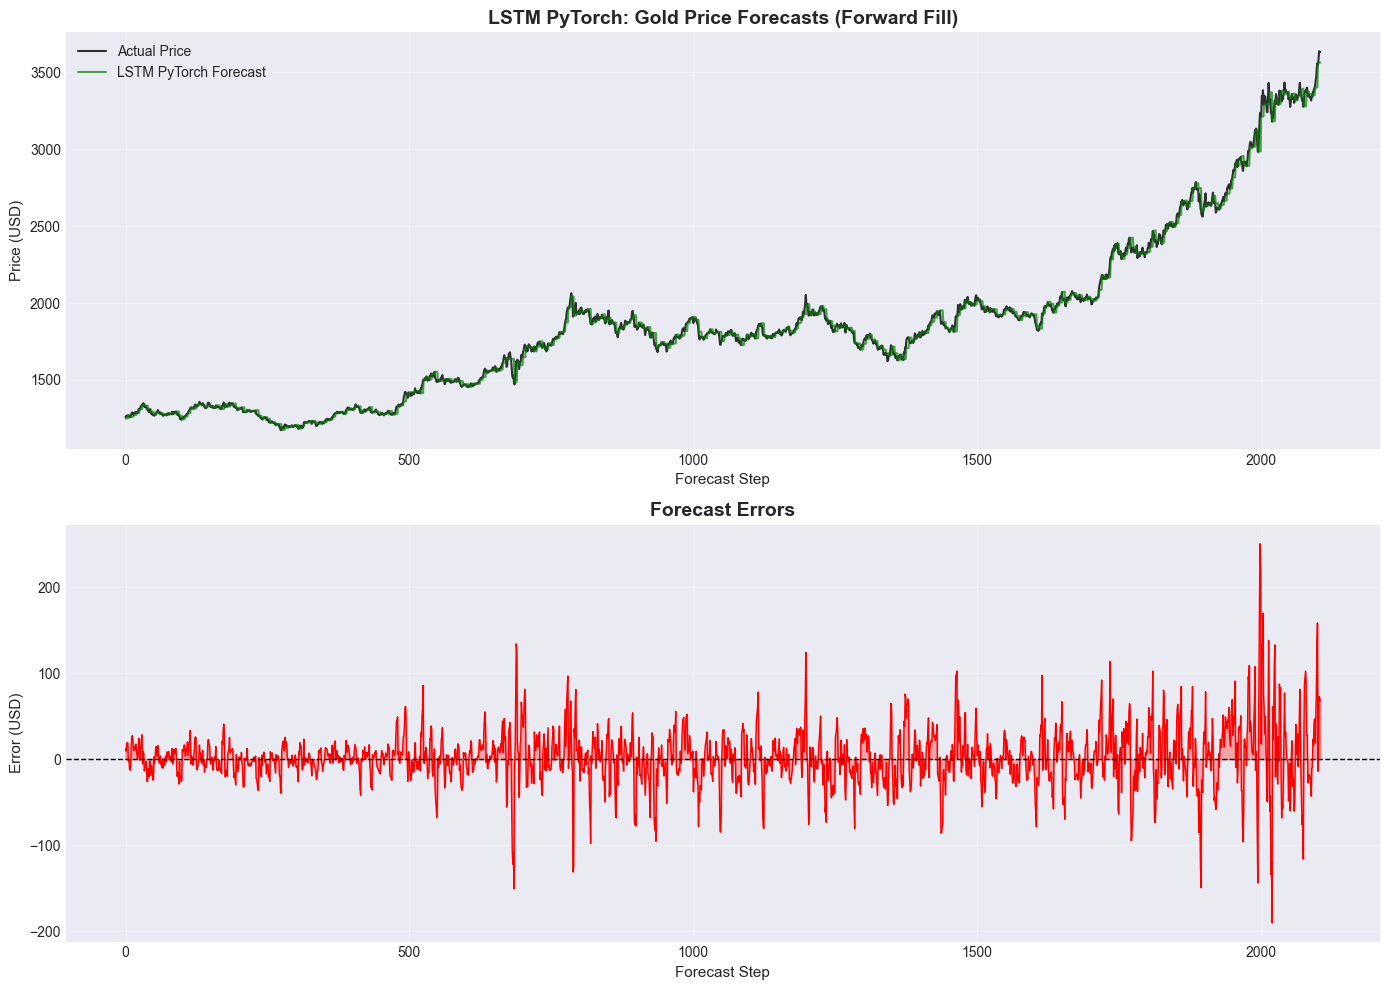

In [52]:
# Plot predictions vs actuals
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Price forecasts
forecast_indices = range(len(predictions_price))
axes[0].plot(forecast_indices, actuals_price, label='Actual Price', 
             color='black', linewidth=1.5, alpha=0.8)
axes[0].plot(forecast_indices, predictions_price, label='LSTM PyTorch Forecast', 
             color='green', linewidth=1.5, alpha=0.7)
axes[0].set_title('LSTM PyTorch: Gold Price Forecasts (Forward Fill)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=11)
axes[0].set_xlabel('Forecast Step', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Forecast errors
errors = actuals_price - predictions_price
axes[1].plot(forecast_indices, errors, color='red', linewidth=1)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1].fill_between(forecast_indices, errors, 0, alpha=0.3, color='red')
axes[1].set_title('Forecast Errors', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error (USD)', fontsize=11)
axes[1].set_xlabel('Forecast Step', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Error Distribution Analysis

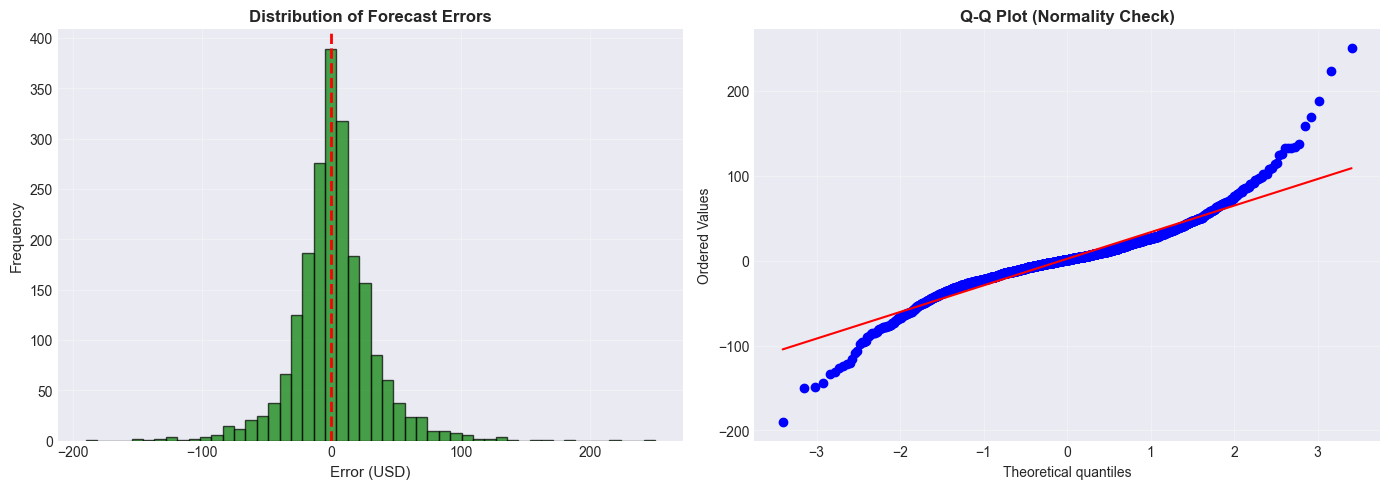

Error Statistics:
  Mean:     $2.22
  Std Dev:  $32.61
  Skewness: 0.4436
  Kurtosis: 6.3224


In [53]:
from scipy import stats

# Analyze error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Distribution of Forecast Errors', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Error (USD)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Q-Q plot
stats.probplot(errors, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Error Statistics:")
print(f"  Mean:     ${np.mean(errors):.2f}")
print(f"  Std Dev:  ${np.std(errors):.2f}")
print(f"  Skewness: {stats.skew(errors):.4f}")
print(f"  Kurtosis: {stats.kurtosis(errors):.4f}")

## 15. Save Model and Results

In [54]:
import os
import joblib

# Create directory
model_dir = '../models/lstm-univar'
os.makedirs(model_dir, exist_ok=True)

# Save results
results = {
    'model': 'LSTM_Univar',
    'rmse': rmse,
    'mae': mae,
    'n_predictions': len(predictions_price),
    'lookback': lookback,
    'forecast_horizon': forecast_horizon,
    'lstm_units_1': 64,
    'lstm_units_2': 32,
    'device': str(device),
    'validation_method': 'forward_fill'
}

results_df = pd.DataFrame([results])
results_df.to_csv(f'{model_dir}/results.csv', index=False)

# Save model (already saved during training as best_model.pt)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lookback': lookback,
    'forecast_horizon': forecast_horizon,
}, f'{model_dir}/final_model.pt')

# Save scalers
joblib.dump(scaler_X, f'{model_dir}/scaler_X.pkl')
joblib.dump(scaler_y, f'{model_dir}/scaler_y.pkl')

print(f"✓ Model and results saved to '{model_dir}/'")
print("\nFiles created:")
print("  - results.csv")
print("  - best_model.pt (best model during training)")
print("  - final_model.pt (complete checkpoint)")
print("  - scaler_X.pkl")
print("  - scaler_y.pkl")

✓ Model and results saved to '../models/lstm-univar/'

Files created:
  - results.csv
  - best_model.pt (best model during training)
  - final_model.pt (complete checkpoint)
  - scaler_X.pkl
  - scaler_y.pkl
